In [28]:
import jax
jax.config.update("jax_enable_x64", True)
import s2fft
import healpy as hp
import numpy as np
import s2wav
import s2wav
import matplotlib.pyplot as plt
%matplotlib inline 
import skyclean
from skyclean import CMB_data

# CMB_map_path = '../data/planck_simulation/ffp10_newdust_total_030_full_map.fits'
CMB_map_path = '/home/max/CMB_plot/code/CMB_realizations/febecop_ffp10_lensed_scl_cmb_040_mc_0000.fits'

CMB_data_30 = skyclean.CMB_data.CMB_Data(CMB_map_path)

CMB_Data object created, (use show_attributes() to check the attributes)


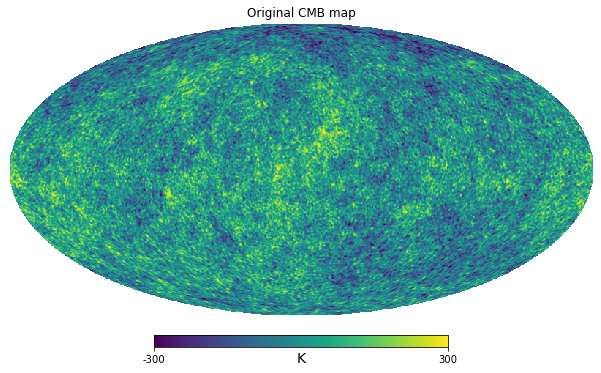

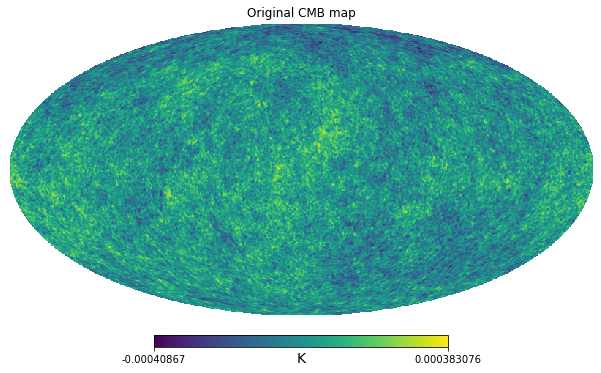

In [31]:
hp.mollview(CMB_data_30.original_hp_map*1e6, title='Original CMB map', unit='K', min=-300, max=300)
hp.mollview(CMB_data_30.original_hp_map, title='Original CMB map', unit='K')

In [7]:
CMB_data_30.original_hp_alm = hp.map2alm(CMB_data_30.original_hp_map, lmax=CMB_data_30.lmax-1)

In [8]:
CMB_data_30.original_mw_alm = CMB_data_30.hp_alm_to_mw_alm(CMB_data_30.original_hp_alm, lmax=CMB_data_30.lmax)

In [10]:
# Frequencies for LFI channels (in GHz)
frequencies = [30, 44, 70]
# Beam FWHM for each frequency (in arcminutes)
beam_fwhm = {30: 32.33, 44: 27.01, 70: 13.25}

# Convert arcminutes to radians
def arcmin_to_radians(arcmin):
    return np.radians(arcmin / 60)

# Define a range of l values
lmax = CMB_data_30.lmax
# l_values = np.arange(0, lmax + 1)  # Start from l=0 to match healpy output

# Plot the Beam Window Functions W_l for each LFI channel
fwhm_rad = arcmin_to_radians(beam_fwhm[30])
bl = hp.sphtfunc.gauss_beam(fwhm_rad, lmax=lmax-1, pol=False)

print(bl.shape)

(2048,)


In [11]:
# To make sure the noise doesn't blow up, we threshold the beam window function
print(bl.min())
thresholded_bl = bl.copy()
thresholded_bl[thresholded_bl < 1e-3] = 1e-3
print(thresholded_bl.min())

3.023745925110047e-15
0.001


In [12]:
CMB_data_30_beam_deconvolved = np.zeros(CMB_data_30.original_mw_alm.shape)

for i in range(CMB_data_30.original_mw_alm.shape[1]):
    CMB_data_30_beam_deconvolved[:, i] = CMB_data_30.original_mw_alm[:, i] / thresholded_bl
CMB_data_30_beam_deconvolved.shape

(2048, 4095)

In [13]:
# Get the Pixel Window Function for the specified nside
pixwin = hp.sphtfunc.pixwin(CMB_data_30.nside, lmax=CMB_data_30.lmax-1, pol=False)

print(pixwin.shape)
print(pixwin.min())

(2048,)
0.8274355847005429


In [14]:
CMB_data_30_pix_beam_deconvolved = np.zeros(CMB_data_30.original_mw_alm.shape)

for i in range(CMB_data_30.original_mw_alm.shape[1]):
    CMB_data_30_pix_beam_deconvolved[:, i] = CMB_data_30_beam_deconvolved[:, i] / pixwin
CMB_data_30_pix_beam_deconvolved.shape

(2048, 4095)

In [15]:
fwhm_rad = arcmin_to_radians(5)
Standard_bl = hp.sphtfunc.gauss_beam(fwhm_rad, lmax=CMB_data_30.lmax-1, pol=False)

print(Standard_bl.shape)

(2048,)


In [16]:
deconvolved_CMB_data_30 = np.zeros(CMB_data_30.original_mw_alm.shape)   


for i in range(CMB_data_30.original_mw_alm.shape[1]):
    deconvolved_CMB_data_30[:, i] = CMB_data_30_pix_beam_deconvolved[:, i] * Standard_bl
deconvolved_CMB_data_30.shape

(2048, 4095)

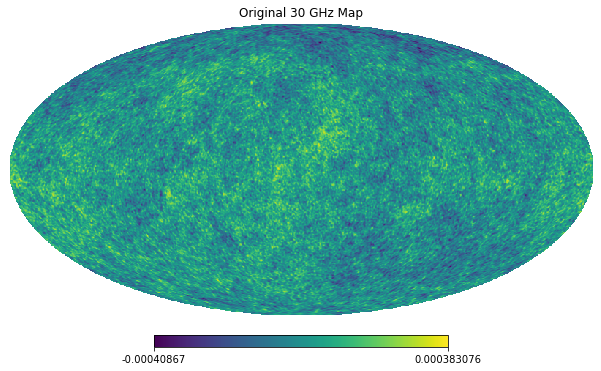

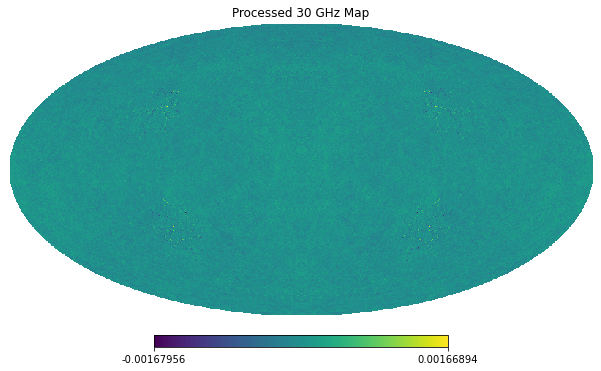

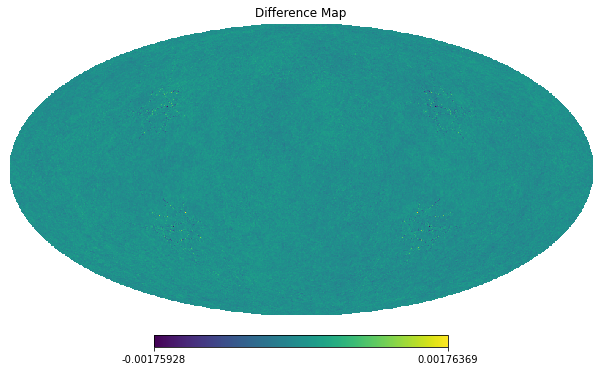

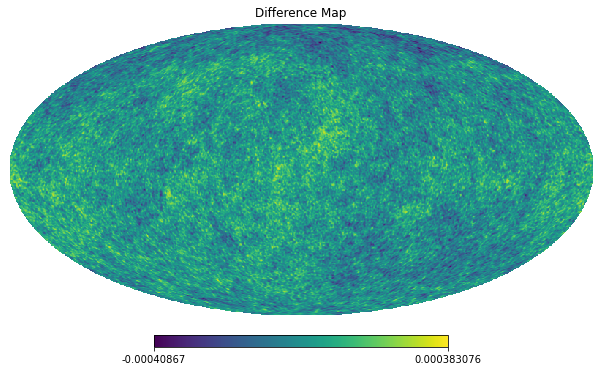

In [20]:
processed_30_hp_alm = CMB_data_30.mw_alm_to_hp_alm(deconvolved_CMB_data_30, lmax=CMB_data_30.lmax)

processed_30_hp_map = hp.alm2map(processed_30_hp_alm, nside=CMB_data_30.nside, lmax=CMB_data_30.lmax-1)

# CMB_data_30.plot_mollview(CMB_data_30.original_hp_map, title='Original 30 GHz Map')
# CMB_data_30.plot_mollview(processed_30_hp_map, title='Processed 30 GHz Map')

# CMB_data_30.plot_mollview(CMB_data_30.original_hp_map - processed_30_hp_map, title='Difference Map')

# CMB_data_30.plot_mollview(processed_30_hp_map+(CMB_data_30.original_hp_map - processed_30_hp_map), title='Difference Map')


hp.mollview(CMB_data_30.original_hp_map, title='Original 30 GHz Map')
hp.mollview(processed_30_hp_map, title='Processed 30 GHz Map')

hp.mollview(CMB_data_30.original_hp_map - processed_30_hp_map, title='Difference Map')

hp.mollview(processed_30_hp_map+(CMB_data_30.original_hp_map - processed_30_hp_map), title='Difference Map')